In [1]:
# Import Libraries
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

In [2]:
!pip install nltk
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab') # Download the missing 'punkt_tab' data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [7]:
%%writefile lofdata.json
 {
  "intents": [
    {
      "tag": "greeting",
      "patterns": [
        "Hai",
        "Halo",
        "P",
        "Ola",
        "Alo"
      ],
      "responses": [
        "Halo! ada yang bisa saya bantu?",
        "Selamat datang di chatbot LOF. Apa yang bisa saya bantu?"
      ]
    },
    {
      "tag": "request_activities",
      "patterns": [
        "Apa saja kegiatan yang bisa saya ikuti?",
        "Ada LOF apa saja yang bisa saya ikuti?",
        "Saya mau ikut LOF"
      ],
      "responses": [
        "Anda dapat mengikuti berbagai LOF yang mencakup bidang kepemimpinan, riset, teknologi, media, dan pengembangan diri. Ada DPM, BEM, K-RISMA, dll."
      ]
    },
    {
      "tag": "bem",
      "patterns": [
        "Apa itu BEM?",
        "BEM itu apasih?"
      ],
      "responses": [
        "- **BEM**: Badan Eksekutif Mahasiswa, untuk pengembangan kepemimpinan dan organisasi."
      ]
    },
    {
      "tag": "dpm",
      "patterns": [
        "Apa itu DPM?",
        "DPM itu apasih?"
      ],
      "responses": [
        "**DPM**: Dewan Perwakilan Mahasiswa, yang berfokus pada legislasi dan pengawasan organisasi mahasiswa."
      ]
    },
    {
      "tag": "krisma",
      "patterns": [
        "Apa itu K-RISMA?",
        "K-RISMA itu apasih?"
      ],
      "responses": [
        "**K-RISMA**: Kelompok Riset Mahasiswa, untuk penelitian dan pengembangan ilmiah."
      ]
    },
    {
      "tag": "optiik",
      "patterns": [
        "Apa itu OPTIIK?",
        "OPTIIK itu apasih?"
      ],
      "responses": [
        "**OPTIIK**: Organisasi pengembangan IT dan inovasi kreatif."
      ]
    },
    {
      "tag": "lpm",
      "patterns": [
        "Apa itu LPM DISPLAY?",
        "LPM DISPLAY itu apasih?"
      ],
      "responses": [
        "**LPM DISPLAY**: Media kampus yang fokus pada jurnalistik dan publikasi."
      ]
    },
    {
      "tag": "raion",
      "patterns": [
        "Apa itu RAION?",
        "RAION itu apasih?"
      ],
      "responses": [
        "**RAION**: Komunitas teknologi untuk pengembangan game dan aplikasi."
      ]
    },
    {
      "tag": "bcc",
      "patterns": [
        "Apa itu BCC?",
        "BCC itu apasih?"
      ],
      "responses": [
        "**BCC**: Komunitas coding untuk peningkatan skill pemrograman."
      ]
    },
    {
      "tag": "hmdtif",
      "patterns": [
        "Apa itu HMDTIF?",
        "HMFTIF itu apasih?"
      ],
      "responses": [
        "**HMDTIF**: Himpunan Mahasiswa Teknik Informatika, fokus pada bidang akademik dan non-akademik informatika."
      ]
    },
    {
      "tag": "join_bcc",
      "patterns": [
        "Bagaimana cara bergabung dengan BCC?",
        "Apa prosedur mendaftar ke BCC?",
        "Saya ingin ikut komunitas coding BCC, bagaimana caranya?"
      ],
      "responses": [
        "Untuk bergabung dengan BCC, kunjungi situs resmi mereka atau gabung melalui grup Telegram yang tersedia.",
        "BCC membuka pendaftaran anggota secara berkala. Ikuti media sosial BCC untuk informasi lebih lanjut.",
        "Pastikan Anda memenuhi syarat dan ketentuan yang ditetapkan oleh BCC sebelum mendaftar.",
        "Hubungi admin atau pengurus BCC untuk mendapatkan panduan lebih lanjut mengenai pendaftaran."
      ]
    },
    {
      "tag": "benefits_bcc",
      "patterns": [
        "Apa manfaat bergabung dengan BCC?",
        "Keuntungan apa yang saya dapat di BCC?",
        "Apa saja manfaat mengikuti kegiatan BCC?"
      ],
      "responses": [
        "Bergabung dengan BCC memberikan akses ke pelatihan coding intensif dan jaringan profesional di dunia IT.",
        "Anda dapat meningkatkan keterampilan coding Anda melalui program mentoring dan proyek nyata di BCC.",
        "BCC menyediakan berbagai seminar dan workshop eksklusif untuk anggotanya.",
        "Komunitas BCC membantu membangun koneksi dengan sesama anggota yang memiliki minat serupa di bidang teknologi."
      ]
    },
    {
      "tag": "join_raion",
      "patterns": [
        "Bagaimana cara bergabung dengan Raion Studio?",
        "Apa langkah pertama untuk bergabung di Raion?",
        "Saya tertarik dengan Raion Studio, bagaimana prosesnya?"
      ],
      "responses": [
        "Untuk mendaftar ke Raion Studio, ikuti informasi pendaftaran di website resmi fakultas atau datang ke open recruitment mereka."
      ]
    },
    {
      "tag": "benefits_raion",
      "patterns": [
        "Apa manfaat bergabung dengan Raion Studio?",
        "Keuntungan apa yang saya dapat di Raion?",
        "Apa saja keuntungan mengikuti kegiatan Raion Studio?"
      ],
      "responses": [
        "Raion Studio membantu Anda mengembangkan keterampilan teknologi seperti pengembangan aplikasi, game development, dan berkolaborasi dalam hackathon."
      ]
    },
    {
      "tag": "join_por",
      "patterns": [
        "Bagaimana cara bergabung dengan POROS?",
        "Apa langkah mendaftar ke POROS?",
        "Saya tertarik dengan POROS, bagaimana cara ikut serta?"
      ],
      "responses": [
        "Untuk bergabung dengan POROS, Anda bisa datang ke open recruitment mereka atau menghubungi admin melalui media sosial."
      ]
    },
    {
      "tag": "benefits_por",
      "patterns": [
        "Apa keuntungan mengikuti POROS?",
        "Manfaat apa yang saya dapat jika bergabung di POROS?",
        "Apa saja manfaat kegiatan POROS?"
      ],
      "responses": [
        "Bergabung di POROS memberikan pengalaman teamwork melalui kegiatan outdoor seperti hiking, outbound, dan pelatihan kepemimpinan."
      ]
    },
    {
      "tag": "join_bios",
      "patterns": [
        "Bagaimana cara bergabung dengan BIOS?",
        "Apa prosedur pendaftaran ke BIOS?",
        "Saya ingin ikut serta di BIOS, bagaimana langkahnya?"
      ],
      "responses": [
        "Anda dapat mendaftar ke BIOS melalui form online atau datang langsung ke stand pendaftaran saat open recruitment."
      ]
    },
    {
      "tag": "benefits_bios",
      "patterns": [
        "Apa keuntungan bergabung di BIOS?",
        "Manfaat apa yang saya dapat di BIOS?",
        "Apa saja manfaat dari kegiatan BIOS?"
      ],
      "responses": [
        "BIOS menyediakan berbagai kegiatan seni, olahraga, dan pengembangan minat seperti paduan suara, teater, dan kompetisi olahraga."
      ]
    },
    {
      "tag": "schedule_lof",
      "patterns": [
        "Kapan jadwal kegiatan LOF?",
        "Apa saja jadwal rutin kegiatan LOF?",
        "Bagaimana cara mengetahui jadwal kegiatan LOF?"
      ],
      "responses": [
        "Jadwal kegiatan LOF dapat dilihat di website resmi fakultas atau akun media sosial masing-masing LOF."
      ]
    },
    {
      "tag": "general_info_lof",
      "patterns": [
        "Apa itu LOF?",
        "Bisakah jelaskan tentang LOF?",
        "Apa fungsi LOF di fakultas ini?"
      ],
      "responses": [
        "LOF adalah Lembaga Otonom Fakultas yang menyediakan berbagai kegiatan pengembangan minat, bakat, dan keterampilan mahasiswa."
      ]
    },
    {
      "tag": "join_bcc_events",
      "patterns": [
        "Kegiatan apa saja yang diselenggarakan oleh BCC?",
        "Apa event rutin yang dilakukan BCC?",
        "Adakah pelatihan atau workshop di BCC?"
      ],
      "responses": [
        "BCC rutin mengadakan workshop, pelatihan coding, dan kompetisi teknologi untuk mahasiswa."
      ]
    },
    {
      "tag": "join_raion_hackathon",
      "patterns": [
        "Apakah Raion sering ikut hackathon?",
        "Bagaimana saya bisa ikut hackathon bersama Raion?",
        "Apakah ada kesempatan berpartisipasi hackathon di Raion Studio?"
      ],
      "responses": [
        "Raion Studio aktif mengikuti hackathon, dan Anda bisa ikut dengan bergabung dalam tim yang mereka bentuk."
      ]
    },
    {
      "tag": "benefits_por_teamwork",
      "patterns": [
        "Apa saja kegiatan teamwork di POROS?",
        "Bagaimana POROS membangun kerja sama tim?",
        "Adakah kegiatan kolaborasi di POROS?"
      ],
      "responses": [
        "POROS mengembangkan kerja sama tim melalui kegiatan seperti hiking kelompok, outbound, dan problem-solving bersama."
      ]
    },
    {
      "tag": "benefits_bios_art",
      "patterns": [
        "Adakah kegiatan seni di BIOS?",
        "Apa saja program seni yang diadakan oleh BIOS?",
        "Bagaimana BIOS mendukung pengembangan seni?"
      ],
      "responses": [
        "BIOS memiliki program seni seperti paduan suara, teater, seni lukis, dan kompetisi kreatif di fakultas."
      ]
    },
    {
      "tag": "umum_minat",
      "patterns": [
        "Saya ingin tahu LOF yang cocok untuk saya.",
        "LOF yang cocok apa?",
        "Ingin join LOF.",
        "Ingin ikut LOF."
      ],
      "responses": [
        "Apa kesenangan kamu?",
        "Apa minat kamu?",
        "Apa yang kamu inginkan?",
        "Apa yang kamu mau?",
        "Apa bakat kamu?"
      ]
    },
    {
      "tag": "recommend_leadership",
      "patterns": [
        "Saya suka kepemimpinan.",
        "Minat saya adalah di bidang leadership.",
        "Saya ingin kegiatan legislatif seperti politik kampus.",
        "Saya ingin mengembangkan kemampuan leadership dan kepemimpinan saya."
      ],
      "responses": [
        "Berikut adalah rekomendasi LOF untuk Anda berdasarkan minat dan bakat yang Anda sebutkan:",
        "LOF **[DPM]**: Fokus pada legislasi dan pengawasan organisasi mahasiswa.",
        "LOF **[BEM]**: Mengembangkan kemampuan kepemimpinan dan organisasi.",
        "LOF **[HMDTIF]**: Himpunan Mahasiswa Teknik Informatika yang fokus pada akademik dan non-akademik informatika.",
        "LOF **[KBMSI]**: Komunitas Mahasiswa Sistem Informasi untuk mendukung kegiatan akademik dan profesional."
      ]
    },
    {
      "tag": "benefit_leadership1",
      "patterns": [
        "Apa keuntungan mengikuti DPM?"
      ],
      "responses": [
        "Manfaat mengikuti LOF DPM meliputi peningkatan kemampuan analisis dalam pengawasan organisasi, pengalaman dalam legislasi mahasiswa, dan pengembangan jaringan dengan tokoh-tokoh kampus."
      ]
    },
    {
      "tag": "benefit_leadership2",
      "patterns": [
        "Apa manfaat ikut BEM?"
      ],
      "responses": [
        "Manfaat mengikuti LOF BEM mencakup pengembangan keterampilan kepemimpinan, pengalaman dalam manajemen organisasi, dan kontribusi langsung pada pengambilan keputusan penting di kampus."
      ]
    },
    {
      "tag": "recommend_krisma",
      "patterns": [
        "Saya suka penelitian dan riset.",
        "Minat saya adalah menulis.",
        "Saya ingin kegiatan berbasis riset.",
        "Saya ingin bergabung dengan tim riset."
      ],
      "responses": [
        "Berikut adalah rekomendasi LOF untuk Anda berdasarkan minat dan bakat yang Anda sebutkan:",
        "LOF **[K-RISMA]**: Kelompok Riset Mahasiswa untuk pengembangan ilmiah dan penelitian.",
        "LOF **[LPM DISPLAY]**: Media kampus yang fokus pada jurnalistik, riset dan publikasi."
      ]
    },
    {
      "tag": "recommend_bcc",
      "patterns": [
        "Saya suka coding dan pengembangan aplikasi.",
        "Minat saya adalah pengembangan website.",
        "Saya ingin belajar coding lebih dalam.",
        "Saya ingin tahu lebih banyak tentang coding."
      ],
      "responses": [
        "Berikut adalah rekomendasi LOF untuk Anda berdasarkan minat dan bakat yang Anda sebutkan:",
        "LOF **[BCC]**: Bootcamp Coding Challenge yang akan mengajarkan Anda pengembangan website dan aplikasi secara menyeluruh.",
        "LOF **[RAION]**: Program pelatihan di Raion untuk Full Stack Web Development dan Machine Learning.",
        "LOF **[ROBOTIK]**: Kursus robotik yang menggabungkan coding dan aplikasi dunia nyata, termasuk penggunaan teknologi AI dan machine learning."
      ]
    }
  ]
}


Overwriting lofdata.json


In [8]:
with open('lofdata.json') as content:
  data1 = json.load(content)

In [9]:
# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [10]:
data

,patterns,tags
0,Hai,greeting
1,Halo,greeting
2,P,greeting
3,Ola,greeting
4,Alo,greeting
...,...,...
79,Saya ingin bergabung dengan tim riset.,recommend_krisma
80,Saya suka coding dan pengembangan aplikasi.,recommend_bcc
81,Minat saya adalah pengembangan website.,recommend_bcc
82,Saya ingin belajar coding lebih dalam.,recommend_bcc


In [11]:
data.head()

,patterns,tags
0,Hai,greeting
1,Halo,greeting
2,P,greeting
3,Ola,greeting
4,Alo,greeting


In [12]:
data.tail()

,patterns,tags
79,Saya ingin bergabung dengan tim riset.,recommend_krisma
80,Saya suka coding dan pengembangan aplikasi.,recommend_bcc
81,Minat saya adalah pengembangan website.,recommend_bcc
82,Saya ingin belajar coding lebih dalam.,recommend_bcc
83,Saya ingin tahu lebih banyak tentang coding.,recommend_bcc


In [13]:
# Removing Punctuations (Menghilangkan Punktuasi)
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))
data

,patterns,tags
0,hai,greeting
1,halo,greeting
2,p,greeting
3,ola,greeting
4,alo,greeting
...,...,...
79,saya ingin bergabung dengan tim riset,recommend_krisma
80,saya suka coding dan pengembangan aplikasi,recommend_bcc
81,minat saya adalah pengembangan website,recommend_bcc
82,saya ingin belajar coding lebih dalam,recommend_bcc


In [14]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

120 unique lemmatized words [',', '.', 'ada', 'adakah', 'adalah', 'alo', 'apa', 'apakah', 'apasih', 'aplikasi', 'atau', 'bagaimana', 'banyak', 'bcc', 'belajar', 'bem', 'berbasis', 'bergabung', 'berpartisipasi', 'bersama', 'bidang', 'bios', 'bisa', 'bisakah', 'cara', 'caranya', 'cocok', 'coding', 'dalam', 'dan', 'dapat', 'dari', 'dengan', 'di', 'diadakan', 'dilakukan', 'diselenggarakan', 'display', 'dpm', 'event', 'fakultas', 'fungsi', 'hackathon', 'hai', 'halo', 'hmdtif', 'hmftif', 'ikut', 'ikuti', 'ingin', 'ini', 'itu', 'jadwal', 'jelaskan', 'jika', 'join', 'k-risma', 'kampus', 'kapan', 'ke', 'kegiatan', 'kemampuan', 'kepemimpinan', 'kerja', 'kesempatan', 'keuntungan', 'kolaborasi', 'komunitas', 'langkah', 'langkahnya', 'leadership', 'lebih', 'legislatif', 'lof', 'lpm', 'manfaat', 'mau', 'membangun', 'mendaftar', 'mendukung', 'mengembangkan', 'mengetahui', 'mengikuti', 'menulis', 'minat', 'ola', 'oleh', 'optiik', 'p', 'pelatihan', 'pendaftaran', 'penelitian', 'pengembangan', 'pertama'

In [15]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

30 classes ['bcc', 'bem', 'benefit_leadership1', 'benefit_leadership2', 'benefits_bcc', 'benefits_bios', 'benefits_bios_art', 'benefits_por', 'benefits_por_teamwork', 'benefits_raion', 'dpm', 'general_info_lof', 'greeting', 'hmdtif', 'join_bcc', 'join_bcc_events', 'join_bios', 'join_por', 'join_raion', 'join_raion_hackathon', 'krisma', 'lpm', 'optiik', 'raion', 'recommend_bcc', 'recommend_krisma', 'recommend_leadership', 'request_activities', 'schedule_lof', 'umum_minat']


In [16]:
# documents = combination between patterns and intents
print (len(documents), "documents")

258 documents


In [17]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])

In [18]:
# Apply padding
x_train = pad_sequences(train)

# Encoding the outputs
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [19]:
print(x_train)

[[  0   0   0   0   0   0   0   0  62]
 [  0   0   0   0   0   0   0   0  63]
 [  0   0   0   0   0   0   0   0  64]
 [  0   0   0   0   0   0   0   0  65]
 [  0   0   0   0   0   0   0   0  66]
 [  0   0   1  12   4   8  26   2  40]
 [  0  41   6   1  12   8  26   2  40]
 [  0   0   0   0   0   2  67  17   6]
 [  0   0   0   0   0   0   1   3  27]
 [  0   0   0   0   0   0  27   3  18]
 [  0   0   0   0   0   0   1   3  28]
 [  0   0   0   0   0   0  28   3  18]
 [  0   0   0   0   0   0   1   3  42]
 [  0   0   0   0   0   0  42   3  18]
 [  0   0   0   0   0   0   1   3  43]
 [  0   0   0   0   0   0  43   3  18]
 [  0   0   0   0   0   1   3  44  45]
 [  0   0   0   0   0  44  45   3  18]
 [  0   0   0   0   0   0   1   3   9]
 [  0   0   0   0   0   0   9   3  18]
 [  0   0   0   0   0   0   1   3  10]
 [  0   0   0   0   0   0  10   3  18]
 [  0   0   0   0   0   0   1   3  68]
 [  0   0   0   0   0   0  69   3  18]
 [  0   0   0   0   7  20  13  14  10]
 [  0   0   0   0   1  46

In [20]:
print(y_train)

[12 12 12 12 12 27 27 27  1  1 10 10 20 20 22 22 21 21 23 23  0  0 13 13
 14 14 14  4  4  4 18 18 18  9  9  9 17 17 17  7  7  7 16 16 16  5  5  5
 28 28 28 11 11 11 15 15 15 19 19 19  8  8  8  6  6  6 29 29 29 29 26 26
 26 26  2  3 25 25 25 25 24 24 24 24]


In [21]:
# input length
input_shape = x_train.shape[1]
print(input_shape)

9


In [22]:
# define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# output length
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  118
output length:  30


In [23]:
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))

In [24]:
pickle.dump(le, open('labelencoder.pkl','wb'))
pickle.dump(tokenizer, open('tokenizer.pkl','wb'))

In [25]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i) # Layer Embedding
x = LSTM(10, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model  = Model(i,x)

# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

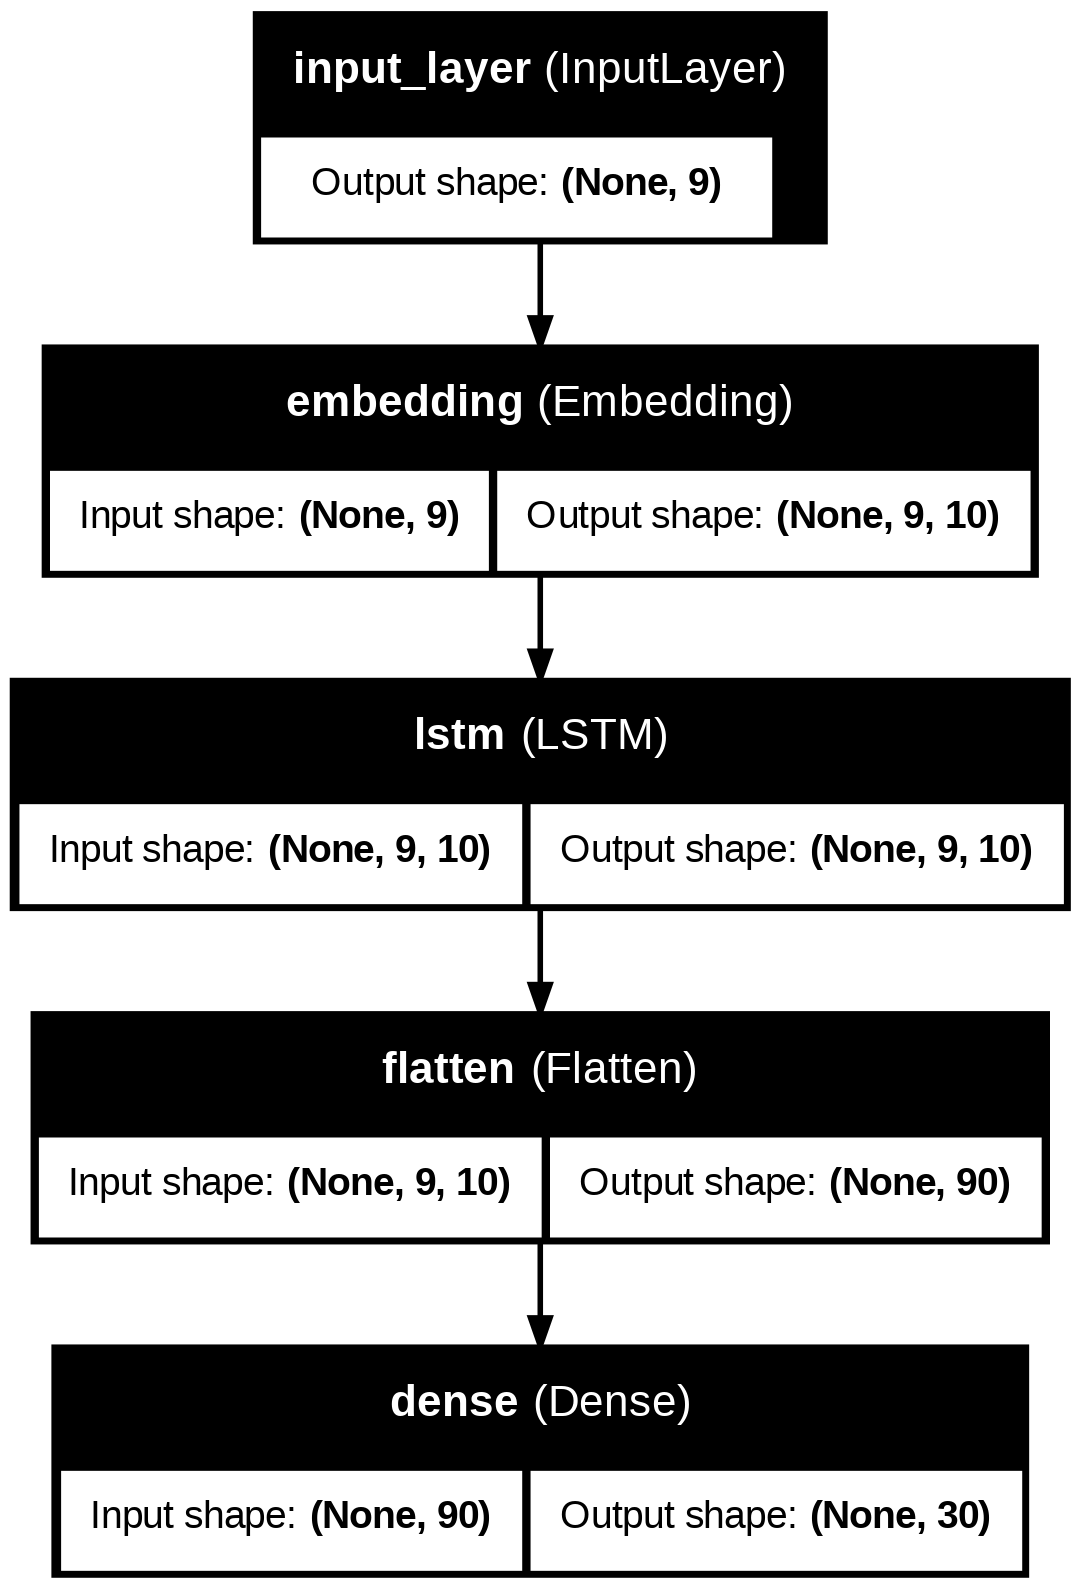

In [26]:
import os

# Creating the directory if it doesn't exist
os.makedirs('/static/img/', exist_ok=True)

# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(model, to_file='/static/img/model_plot.png', show_shapes=True, show_layer_names=True)

In [27]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 9)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 9, 10)               │           1,190 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 9, 10)               │             840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 90)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │           2,730 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,760 (18.59 KB)

 Trainable params: 4,760 (18.59 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Training the model (Latih Model Data)
train = model.fit(x_train, y_train, epochs=500)

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0218 - loss: 3.4005  
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0415 - loss: 3.3984     
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0670 - loss: 3.3959 
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0748 - loss: 3.3938 
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0865 - loss: 3.3901 
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0610 - loss: 3.3875 
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0787 - loss: 3.3831 
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0670 - loss: 3.3816
Epoch 9/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0670 - loss: 3.3778
Epoch 10/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0709 - loss: 3.3734 
Epoch 11/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0649 - loss: 3.3649 
Epoch 12/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0805

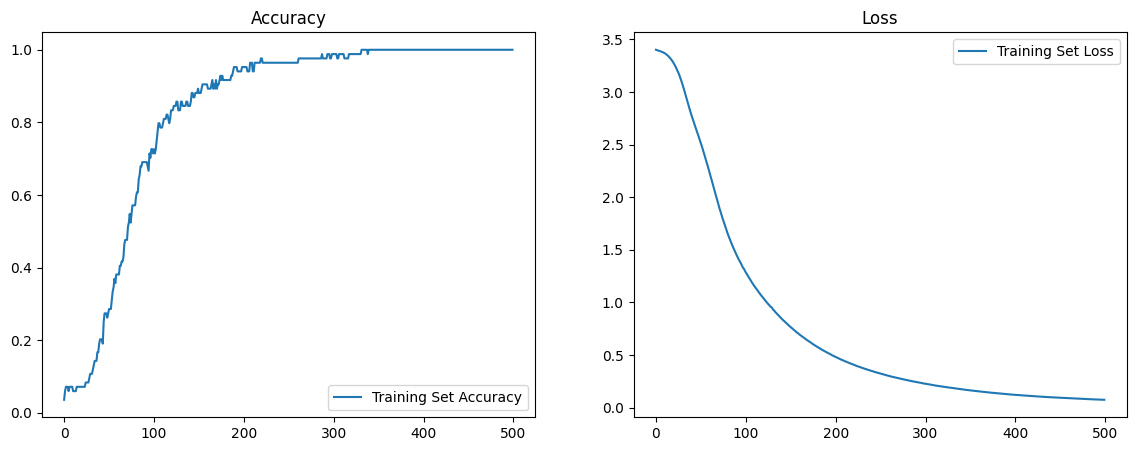

In [29]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'],label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [30]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on train data")
print("Training Set Accuracy: ", train.history['accuracy'][-1])
print("Training Set Loss: ", train.history['loss'][-1])

Evaluate on train data
Training Set Accuracy:  1.0
Training Set Loss:  0.07566098123788834


In [32]:

# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('Kamu : ')

  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  # Mendapatkan hasil keluaran pada model
  output = model.predict(prediction_input)
  output = output.argmax()

# # Menemukan respon sesuai data tag
  response_tag = le.inverse_transform([output])[0]
  print("Chatbot : ", random.choice(responses[response_tag]))
  print("="*60 + "\n")
  if response_tag == "goodbye":
    break

Kamu : p
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Chatbot :  Selamat datang di chatbot LOF. Apa yang bisa saya bantu?

Kamu : hai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Chatbot :  Selamat datang di chatbot LOF. Apa yang bisa saya bantu?

Kamu : ingin ikut lof
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Chatbot :  Apa bakat kamu?

Kamu : saya suka coding
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Chatbot :  Apa yang kamu inginkan?

Kamu : saya ingin belajar coding lebih dalam
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Chatbot :  LOF **[RAION]**: Program pelatihan di Raion untuk Full Stack Web Development dan Machine Learning.



KeyboardInterrupt: Interrupted by user